<a href="https://colab.research.google.com/github/yizhoucc/turtorials/blob/main/notebooks/LDM_background_remove_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDM background remove demo

masks from prompts with SAM


## Environment Set-up

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-eqqumwai
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-eqqumwai
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=4418538f18e9d4ef44783a212157e2646355725dacad7ee4dc3a409332ee5678
  Stored in directory: /tmp/pip-ephem-wheel-cache-zy1w2ugw/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-07-29 13:09:27--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import label, generate_binary_structure


In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def flip_surrounded_regions(mask):
    # Invert the mask
    inverted_mask = ~mask

    # Label connected components
    structure = generate_binary_structure(2, 2)  # 8-connectivity
    labeled_array, num_features = label(inverted_mask, structure=structure)

    # Identify labels that touch the border
    border_labels = np.unique(
        np.concatenate([
            labeled_array[0, :],
            labeled_array[-1, :],
            labeled_array[:, 0],
            labeled_array[:, -1]
        ])
    )

    # Create a mask for labels not touching the border
    surrounded_mask = np.isin(labeled_array, border_labels, invert=True)
    # Flip
    mask[surrounded_mask] = ~mask[surrounded_mask]
    return mask


In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## demo data


In [ ]:
!curl -o images/sofa.jpg "https://encrypted-tbn0.gstatic.com/shopping?q=tbn:ANd9GcT-juUQrr0nr_i0xC6BEBF_Zs4M_p-kxb1jXWnUlmnwhu3wygP02k_kcQDlO4OMZzfjn8Qkd1qoxcR8A3QYglEHK36Smu_uExAD8V3_5Po"
!curl -o images/shoe.jpg "https://image.localdealmarket.shop/public/media/28/0342a612-cb2b-4348-a315-cea2b7119a27?width=300"



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30660  100 30660    0     0   511k      0 --:--:-- --:--:-- --:--:--  516k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18830  100 18830    0     0   6114      0  0:00:03  0:00:03 --:--:--  6115


## point demo

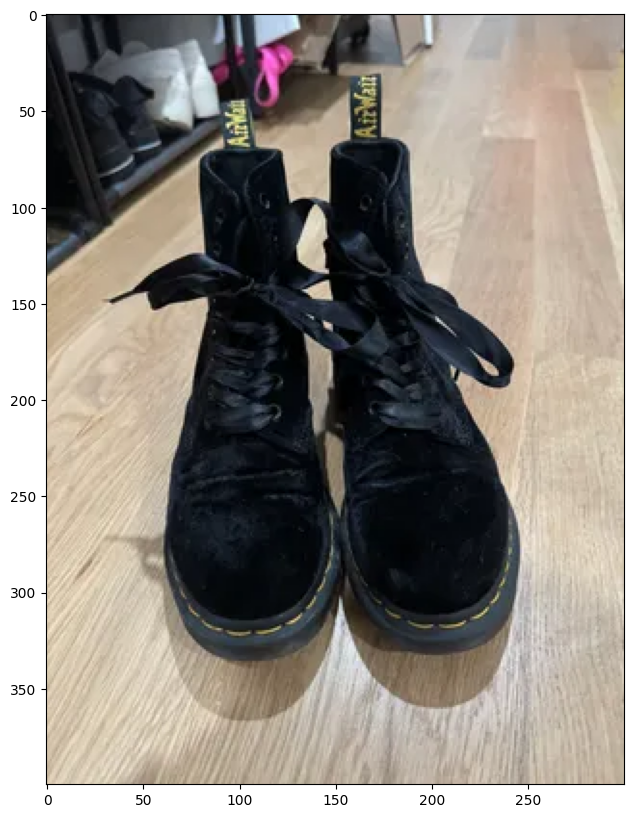

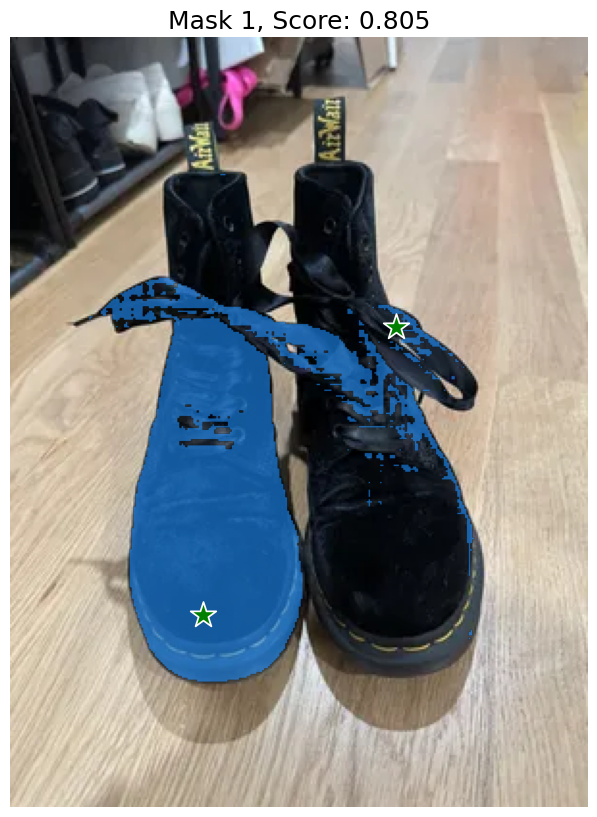

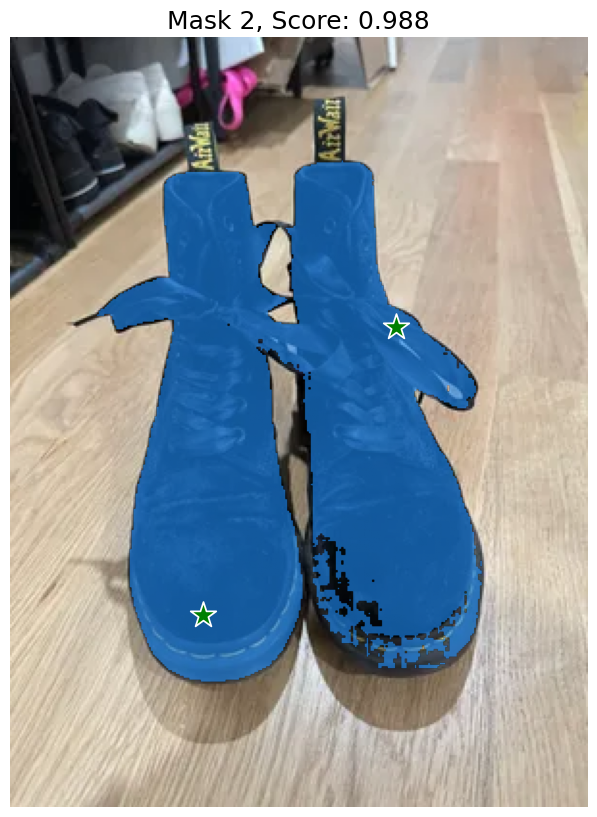

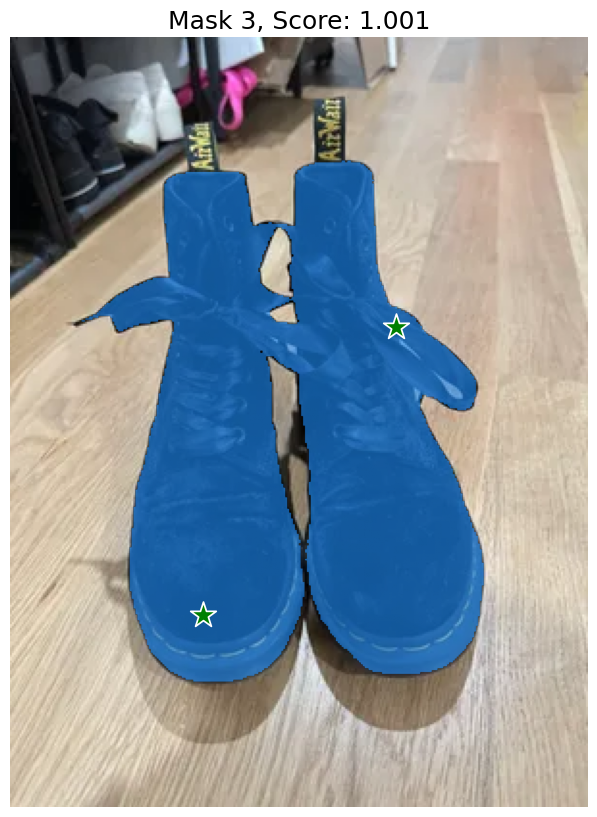

In [ ]:
image = cv2.imread('images/shoe.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

input_point= np.array([[100, 300],[200,150]])
input_label = np.ones_like(input_point[:,0])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
# oringal img
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


## box demo


In [ ]:
image = cv2.imread('images/groceries.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

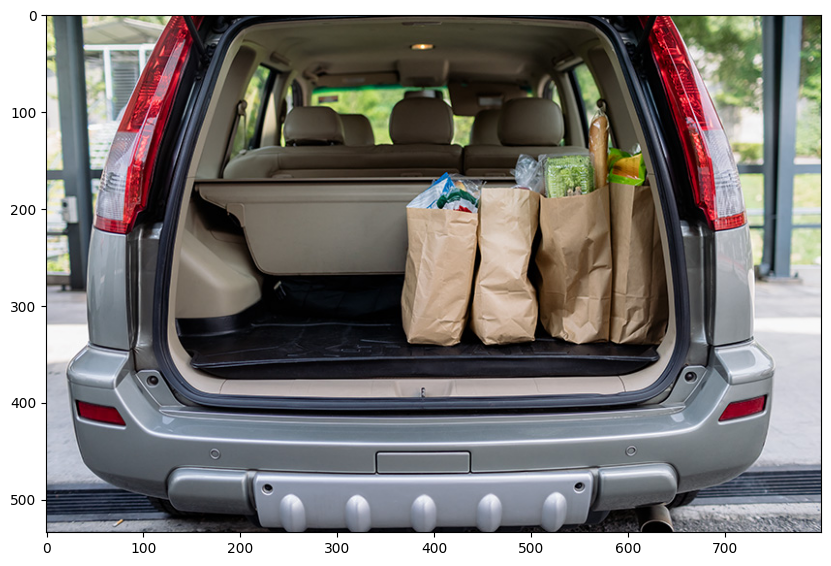

In [ ]:
# oringal img
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

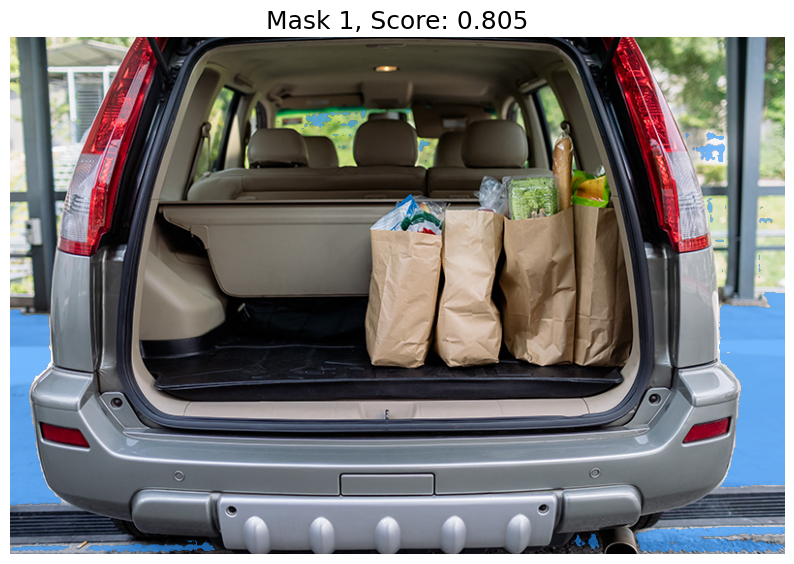

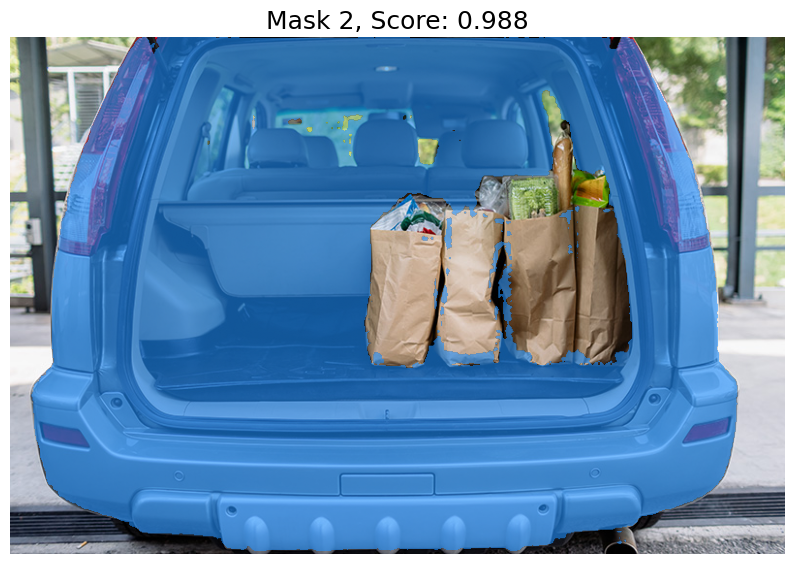

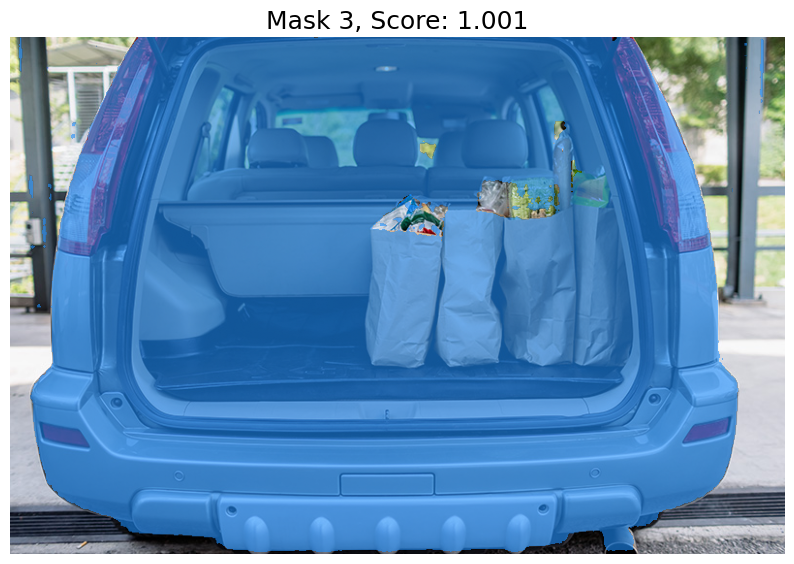

In [ ]:
input_box = np.array([0, 0, len(image[0]), len(image)])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

2

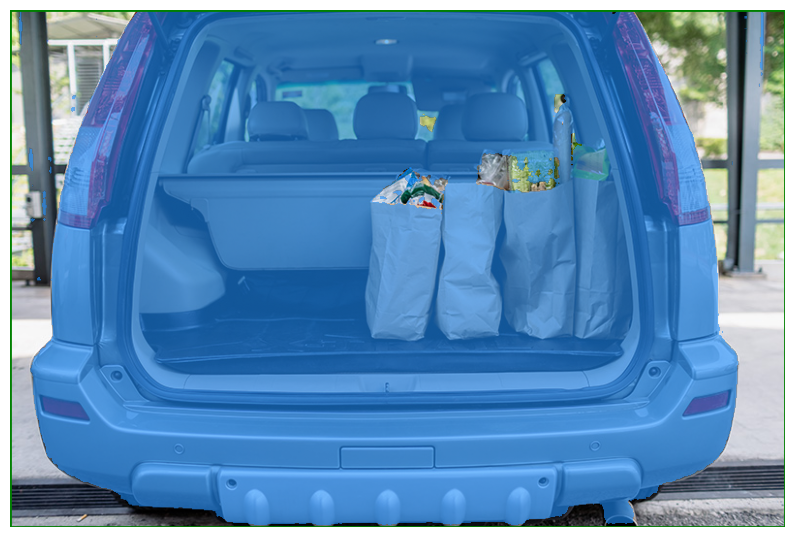

In [ ]:
# model out (best)
bestind=np.argmax(scores)


plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[bestind], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

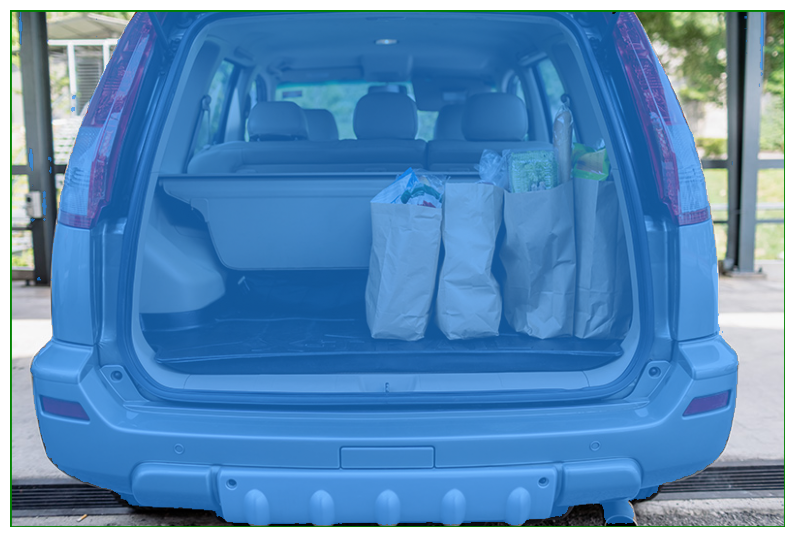

In [ ]:
# post process (if needed. use feather score to determine if we need post proecssing.)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(flip_surrounded_regions(masks[bestind]), plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## box and point demo

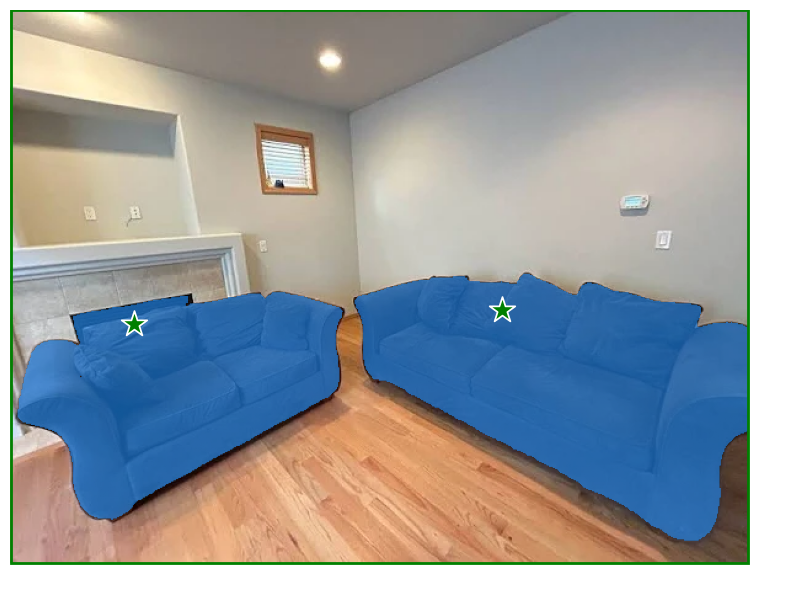

In [ ]:
image = cv2.imread('images/sofa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

input_box = np.array([0, 0, image.shape[1], image.shape[0]])
input_point = np.array([[100, 255], [400, 244]])
input_label = np.ones_like(input_point[:,0])
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    # box=input_box,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

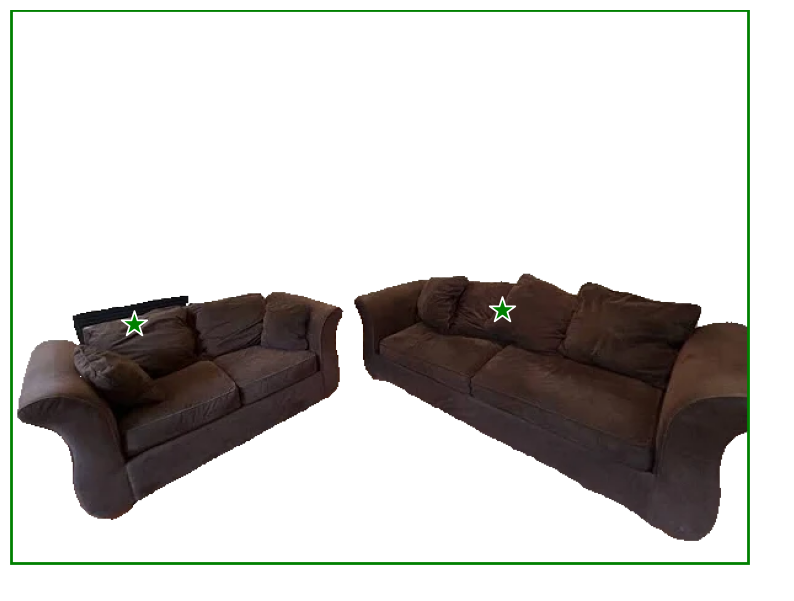

In [ ]:
# remove background

# create background
white_image = np.ones_like(image) * 255
result_img = np.where(masks[0][:, :, None], image, white_image)

plt.figure(figsize=(10, 10))
plt.imshow(result_img)
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()